# [실습 1] RNN 모델을 이용한 영화리뷰 감성 분류 모델 구현

## 실습 목표
---
1. 파이썬 라이브러리를 활용하여 텍스트 데이터를 전처리합니다.
2. Pytorch 라이브러리를 이용하여 LSTM 감정 분류 모델을 구현하고, 학습시켜 결과를 확인합니다.
3. GRU를 활용하여 모델을 구현해보고, 이를 LSTM모델의 결과와 비교해봅니다.

# LSTM을 활용한 감성 분석(SA, Sentiment Analysis) 모델

## 1. 모듈 불러오기 및 환경 설정

주요 라이브러리에 대한 간단한 설명입니다.  

- re: 정규 표현식을 사용하여 문자열을 처리하는 라이브러리입니다. 복잡한 문자열 검색, 치환, 분할 등을 수행할 수 있습니다.

- string: 문자열 상수와 일반적인 문자열 처리를 위한 유틸리티 함수를 제공합니다.

- numpy: 과학 계산을 위한 핵심 라이브러리로, 다차원 배열 객체와 이러한 배열 작업을 위한 다양한 함수를 제공합니다.

- pandas: 데이터 분석과 조작을 위한 라이브러리로, 특히 데이터 프레임과 시리즈와 같은 데이터 구조를 제공합니다.

- tqdm: 진행 표시줄을 쉽게 추가할 수 있게 해주는 라이브러리로, 반복문의 진행 상황을 시각적으로 표시합니다.

- collections: 파이썬의 내장 컨테이너 데이터 타입을 확장하는 모듈로, Counter와 같은 유용한 데이터 구조를 제공합니다.

- seaborn: Matplotlib을 기반으로 한 데이터 시각화 라이브러리로, 통계 그래프를 그리는 데 사용됩니다.

- matplotlib.pyplot: 데이터를 시각화하기 위한 2D 플로팅 라이브러리입니다. 다양한 차트와 그래프를 그릴 수 있습니다.

- torch: 딥러닝 프레임워크인 PyTorch의 핵심 라이브러리로, 텐서 계산과 GPU 가속 등을 제공합니다.

- torch.nn.functional: 신경망 구축에 사용되는 함수들을 포함하고 있습니다. 활성화 함수, 손실 함수 등이 여기에 포함됩니다.

- torch.utils.data: 데이터 로딩을 위한 유틸리티가 포함된 패키지로, TensorDataset, DataLoader 등의 클래스를 제공합니다.

- sklearn.model_selection: Scikit-learn의 모델 선택 모듈로, 데이터를 훈련 세트와 테스트 세트로 분할하는 기능 등을 제공합니다.

- from sklearn.metrics:  Scikit-learn의 평가지표를 모아놓은 API입니다.

In [ ]:
import os
import re
import string
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

torch.__version__

'2.2.1+cu121'

현재 시스템에서 GPU가 사용 가능한지 확인하고, 사용 가능한 경우 디바이스를 CUDA로 설정합니다.  

GPU가 사용 불가능한 경우 디바이스를 CPU로 설정합니다.  

이렇게 설정한 디바이스는 나중에 텐서 연산에 사용될 수 있습니다.

In [ ]:
# GPU가 존재할 경우 사용합니다.
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


후에 모델 파일을 저장할 위치도 생성합니다.

In [ ]:
!mkdir ./save_files

!ls -al

mkdir: cannot create directory ‘./save_files’: File exists
total 64688
drwxr-xr-x 1 root root     4096 Apr  4 02:05  .
drwxr-xr-x 1 root root     4096 Apr  4 02:01  ..
drwxr-xr-x 4 root root     4096 Apr  2 13:22  .config
drwx------ 5 root root     4096 Apr  4 02:05  drive
-rw-r--r-- 1 root root 66212309 Apr  4 02:10 'IMDB Dataset.csv'
drwxr-xr-x 1 root root     4096 Apr  2 13:23  sample_data
drwxr-xr-x 2 root root     4096 Apr  4 02:04  save_files


## 2. 데이터셋 불러오기 & 전처리

이번 실습에서는 [`IMDB(Internet Movie Database)`](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) 데이터셋을 사용합니다.  

IMDB 데이터셋은 영화, 텔레비전 쇼, 비디오 게임, 배우, 감독, 제작자 등 엔터테인먼트 산업과 관련된 다양한 정보를 포함하고 있는 데이터베이스입니다.  

원본 데이터셋에는 영화 평점, 리뷰, 메타데이터, 장르, 출시일, 상영 시간, 예산, 수익 등과 같은 정보를 포함하고 있습니다.  

다만 이번 시간에는 자연어처리 모델을 만들고 성능을 평가하는 것이 목표이므로, 준비된 데이터는 시청자들의 리뷰와 이에 대한 평가 데이터만을 사용되도록 처리되어있습니다.  

경로를 설정하고, csv파일을 Pandas Dataframe으로 불러와봅시다.

In [ ]:
PATH = '/content/IMDB Dataset.csv'

데이터셋은 아래와 같이 두 개의 Column으로 구성되어 있습니다.

- review: 시청자들의 후기가 문자열로 기록
- sentiment: 수치로 기록된 평점을 긍정(positive)과 부정(negative)로 구분지어 놓음

In [ ]:
import pandas as pd

# Replace 'PATH' with the actual path of your CSV file
PATH =  '/content/IMDB Dataset.csv'
try:
    df = pd.read_csv(PATH, error_bad_lines=False, engine='python')
    print(df.head())
except Exception as e:
    print(f"An error occurred: {e}")


An error occurred: read_csv() got an unexpected keyword argument 'error_bad_lines'


In [ ]:
df = pd.read_csv(PATH)
df.head()   # 상위 5줄을 출력해봅시다.

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### 2.1 중복 제거
데이터의 통계치를 살펴보겠습니다.  

`df.describe()`메서드를 쓰면 데이터프레임의 전체 샘플 수(count), 중복되지 않는 행의 수(unique) 등을 확인할 수 있습니다.

In [ ]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


위와 같이 일부 리뷰에 중복이 있는 것을 확인할 수 있습니다.  

이를 찾아 제거해보겠습니다.  

`df.duplicated()`메서드는 모든 열에 대한 값이 동일한 샘플들을 반환합니다.

In [ ]:
# 중복된 행 찾기
duplicates = df.duplicated()
print(df[duplicates])

                                                  review sentiment
3537   Quite what the producers of this appalling ada...  negative
3769   My favourite police series of all time turns t...  positive
4391   Beautiful film, pure Cassavetes style. Gena Ro...  positive
6352   If you liked the Grinch movie... go watch that...  negative
6479   I want very much to believe that the above quo...  negative
...                                                  ...       ...
49912  This is an incredible piece of drama and power...  positive
49950  This was a very brief episode that appeared in...  negative
49984  Hello it is I Derrick Cannon and I welcome you...  negative
49986  This movie is a disgrace to the Major League F...  negative
49991  Les Visiteurs, the first movie about the medie...  negative

[418 rows x 2 columns]


중복된 데이터를 삭제하도록 하겠습니다.  

이는 `df.drop_duplicates()` 메서드를 통해 실행할 수 있습니다.

In [ ]:
# 중복된 행 제거
df = df.drop_duplicates()
df.describe()

,review,sentiment
count,49582,49582
unique,49582,2
top,One of the other reviewers has mentioned that ...,positive
freq,1,24884


### 2.2 텍스트 전처리 함수 생성

데이터의 중복을 제거했다면, 이번엔 각 리뷰를 전처리하겠습니다.  

리뷰 전처리 과정에는 아래 항목들이 포함됩니다.

- 소문자 변환

-  HTML 태그 제거

- 구두점 제거

- 불용어 제거  

해당 전처리 과정들의 내용을 예시코드와 함께 보도록 하겠습니다.

#### 소문자 변환
- 메서드 `lower()`로 문자열의 모든 대문자를 소문자로 변환합니다.

In [ ]:
text = "Lorem Ipsum DOLOR sit Amet."
print(text)
lower_text = text.lower()
print(lower_text)  # 출력: "lorem ipsum dolor sit amet."

Lorem Ipsum DOLOR sit Amet.
lorem ipsum dolor sit amet.


####  HTML 태그 제거

-  HTML 태그는 텍스트 내용과 관련이 없으므로 정규식을 사용해 제거합니다.
- `re.sub`: re 모듈의 sub 함수는 정규식을 사용하여 문자열에서 패턴을 찾아 다른 문자열로 대체합니다.
```
text = re.sub('<.*?>', '', text)
```

- `<`: 태그의 시작을 나타내는 괄호입니다.
- `.*?`:
    - `.`은 어떤 문자든지 매치할 수 있으며,

    - `*`은 바로 앞의 문자가 0번 이상 반복될 수 있음을 나타냅니다.
    
    - `?`은 이전 요소가 최소한으로 매치되어야 함을 나타내는 "비탐욕적(Non-greedy)" 수량자입니다.
    
- `>`: 태그의 끝을 나타내는 괄호입니다.

In [ ]:
import re

text = "<p>Lorem <b>Ipsum</b> DOLOR.</p>"
print(text)
clean_text = re.sub('<.*?>', '', text)
print(clean_text)  # 출력: "Lorem Ipsum DOLOR."

<p>Lorem <b>Ipsum</b> DOLOR.</p>
Lorem Ipsum DOLOR.


#### 구두점 제거
리스트 컴프리헨션과 `string.punctuation`을 사용하여 구두점을 제거합니다.

In [ ]:
import string

text = "Lorem Ipsum, DOLOR: sit Amet!"
print(text)
clean_text = ''.join([c for c in text if c not in string.punctuation])
print(clean_text)  # 출력: "Lorem Ipsum DOLOR sit Amet"

Lorem Ipsum, DOLOR: sit Amet!
Lorem Ipsum DOLOR sit Amet


#### 불용어 제거
- 불용어는 텍스트 분석에 큰 의미를 가지지 않는 단어입니다.

- `split` 메서드와 리스트 컴프리헨션을 사용하여 불용어를 제거합니다.

- 불용어는 상황에 따라 이용자가 설정하는 것이 가장 좋으나, 이번에는 nltk 라이브러리의 stopwords를 이용해보겠습니다.

위에서 안내된 전처리 과정들을 `data_preprocessing`함수에 포함시켜 선언해보겠습니다.  

우선 NLTK 라이브러리의 stopwords를 다운받습니다.

In [ ]:
import nltk

nltk.download('stopwords') # NLTK에서 불용어 데이터를 다운로드
stop_words = set(nltk.corpus.stopwords.words('english')) # 영어 불용어 목록을 가져와서 집합으로 저장

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


자주 사용되는 Stopwords를 몇 가지 살펴보겠습니다.  

Stopwords의 경우 set 타입으로 저장되어 있기에, 이를 list로 변환하여 살펴보겠습니다.

In [ ]:
subset = list(stop_words)[:20]
print(subset)

["you're", 'ma', 'do', 'ourselves', 'that', 'll', 'can', 'doing', 'once', 'hasn', 'will', 'out', 'any', 'during', 'nor', 'above', 'all', 'up', "hasn't", 'into']


### [TODO] 전처리 함수를 만들어봅시다.

앞서 설명한 네 개의 전처리 과정을 거친 후, 공백 기준으로 분할된 단어들을 다시 이어붙이는 함수를 선언합니다.

텍스트 데이터의 흐름이 잘 이어질 수 있도록 만들어주세요.

In [ ]:
# 텍스트 데이터 전처리 함수
def data_preprocessing(text):
    text = text.lower() # 모든 문자를 소문자로 변환
    text = re.sub('<.*?>', '', text) # HTML 태그 제거 (정규식을 사용하여 <와 > 사이의 모든 문자 제거)
    text = ''.join([c for c in text if c not in string.punctuation]) # 구두점 제거
    text = [word for word in text.split() if word not in stop_words] # 불용어 제거 (stop_words 리스트에 없는 단어만 유지)
    text = ' '.join(text) # 단어 리스트를 공백으로 구분된 문자열로 다시 결합
    return text # 전처리된 텍스트 반환

> 예시코드
```
# 텍스트 데이터 전처리 함수
def data_preprocessing(text):
    text = text.lower() # 모든 문자를 소문자로 변환
    text = re.sub('<.*?>', '', text) # HTML 태그 제거 (정규식을 사용하여 <와 > 사이의 모든 문자 제거)
    text = ''.join([c for c in text if c not in string.punctuation]) # 구두점 제거
    text = [word for word in text.split() if word not in stop_words] # 불용어 제거 (stop_words 리스트에 없는 단어만 유지)
    text = ' '.join(text) # 단어 리스트를 공백으로 구분된 문자열로 다시 결합
    return text # 전처리된 텍스트 반환
```

위의 함수를 데이터프레임의 `review` 열마다 적용한 뒤, 전처리된 내용을 `cleansed_reviews` 열에 저장하겠습니다.  

함수를 데이터프레임에 적용하기 위해선 `apply()` 메서드를 사용합니다.

In [ ]:
df['cleaned_reviews'] = df['review'].apply(data_preprocessing)  # 데이터프레임의 review에 대해 전처리 함수를 적용한 내용을 cleaned_reviews 컬럼에 저장합니다.
df.head()

,review,sentiment,cleaned_reviews
0,One of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching 1 oz episode ...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically theres family little boy jake thinks...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...


위와 같이 정상적으로 모든 후기에 대해 전처리가 적용되어 저장된 것을 확인하실 수 있습니다.

### 2.3 단어 빈도수 확인
이번에는 자주 사용된 단어를 확인하고, 이를 시각화하여 확인하는 과정을 가져보겠습니다.  

우선 정제된 리뷰에서 모든 단어를 추출한 뒤, 빈도를 계산합니다.  

이어 빈도 순으로 단어를 재정렬하는 과정을 거치겠습니다.

In [ ]:
# 데이터프레임의 'cleaned_reviews' 열에서 모든 단어를 추출하여 리스트로 만듭니다.
corpus = [word for text in df['cleaned_reviews'] for word in text.split()]

# Counter 객체를 사용하여 각 단어의 빈도수를 계산합니다.
count_words = Counter(corpus)

# 빈도수가 높은 순서대로 단어를 정렬합니다.
sorted_words = count_words.most_common()

### [TODO] 가장 많이 사용된 단어 20개를 추출하여 그래프로 표현해주세요

아래 코드의 빈칸을 채워 시각화해주세요.

가로축은 단어, 세로축은 빈도를 표현합니다.

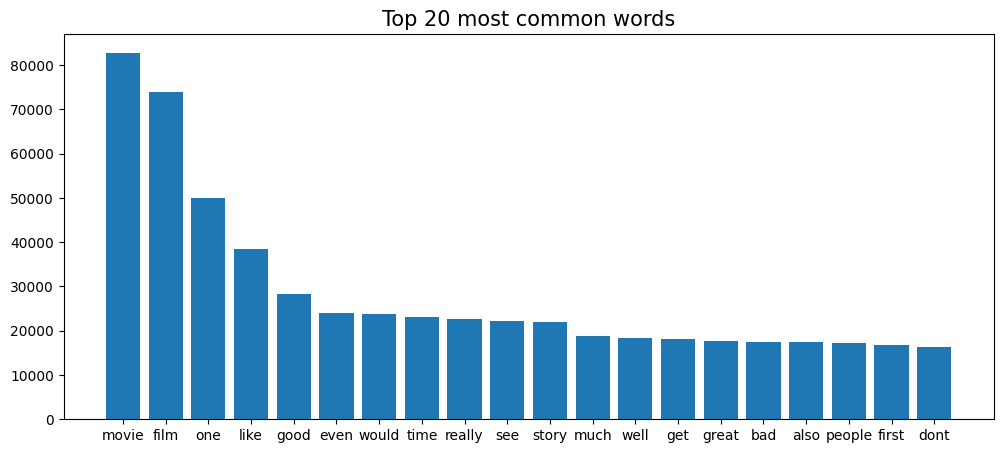

In [ ]:
# 상위 20개의 가장 흔한 단어와 그 빈도수를 저장할 리스트를 초기화합니다.
keys = []
values = []
for key, value in sorted_words[:20]: # 상위 20개의 단어와 빈도수를 반복합니다.
    keys.append(key) # 단어를 keys 리스트에 추가합니다.
    values.append(value) # 빈도수를 values 리스트에 추가합니다.

plt.figure(figsize=(12, 5)) # 그림 크기를 설정합니다.
plt.bar(keys, values) # 막대 그래프를 그립니다. x축은 단어, y축은 빈도수입니다.
plt.title('Top 20 most common words', size=15) # 그래프의 제목을 설정합니다.
plt.show() # 그래프를 표시합니다.

> 예시코드
```
# 상위 20개의 가장 흔한 단어와 그 빈도수를 저장할 리스트를 초기화합니다.
keys = []
values = []
for key, value in sorted_words[:20]: # 상위 20개의 단어와 빈도수를 반복합니다.
    keys.append(key) # 단어를 keys 리스트에 추가합니다.
    values.append(value) # 빈도수를 values 리스트에 추가합니다.

plt.figure(figsize=(12, 5)) # 그림 크기를 설정합니다.
plt.bar(keys, values) # 막대 그래프를 그립니다. x축은 단어, y축은 빈도수입니다.
plt.title('Top 20 most common words', size=15) # 그래프의 제목을 설정합니다.
plt.show() # 그래프를 표시합니다.
```

### 2.4 토큰화

토큰화는 자연어 처리에서 중요한 전처리 과정 중 하나로, 텍스트를 더 작은 단위인 '토큰'으로 분리하는 작업을 말합니다.  

토큰은 일반적으로 단어 또는 문장으로 정의되며, 이는 문맥에 따라 다릅니다.  

토큰화를 통해 텍스트 데이터를 딥러닝 알고리즘이 처리할 수 있는 형태로 변환할 수 있습니다.  

이 코드에서는 토큰화를 수행한 후 각 토큰(단어)을 정수로 변환하는 작업을 수행합니다.  

이를 '정수 인코딩'이라고 하며, 이는 컴퓨터가 텍스트 데이터를 이해하고 처리할 수 있도록 돕습니다.  

아래 코드의 과정은 다음과 같습니다:

1. 먼저, 가장 빈번하게 등장하는 단어에 낮은 정수를 할당하는 단어-정수 매핑 사전을 생성합니다. 이 사전은 `vocab_to_int`에 저장됩니다.

2. 그런 다음, 각 리뷰를 순회하며 각 단어를 해당 정수로 변환합니다. 이 변환된 리뷰는 `reviews_int` 리스트에 추가됩니다.

3. 마지막으로, 변환된 리뷰를 원래 데이터프레임의 새로운 열 `Review int`에 추가합니다.

In [ ]:
# 단어를 정수로 매핑하는 사전을 생성합니다. 가장 흔한 단어는 1, 그 다음은 2, ...
vocab_to_int = {w: i + 1 for i, (w, c) in enumerate(sorted_words)}

reviews_int = [] # 리뷰를 정수로 변환한 결과를 저장할 리스트를 초기화합니다.
for text in df['cleaned_reviews']: # 'cleaned_reviews' 열의 각 텍스트에 대해 반복합니다.
    r = [vocab_to_int[word] for word in text.split()] # 각 단어를 해당 정수로 변환합니다.
    reviews_int.append(r) # 변환된 리뷰를 reviews_int 리스트에 추가합니다.

print(reviews_int[:1]) # 변환된 리뷰 중 첫 번째 리뷰를 출력합니다.
df['Review int'] = reviews_int # 변환된 리뷰를 데이터프레임의 새 열 'Review int'에 저장합니다.

[[3, 1830, 939, 56, 398, 3226, 290, 350, 3029, 107, 482, 471, 7377, 19, 57, 3093, 3226, 5348, 14771, 50, 475, 180, 107, 550, 52, 1604, 41, 7988, 5551, 11400, 41, 2361, 5802, 5461, 1334, 277, 475, 3266, 245, 234, 60572, 351, 3226, 11075, 238, 15692, 6626, 2407, 943, 60573, 2483, 1252, 24395, 421, 4533, 2391, 1075, 6903, 2835, 12488, 300, 60574, 16798, 212, 4900, 3560, 421, 236, 82180, 8124, 39645, 15060, 4965, 7571, 2318, 16799, 60575, 224, 9005, 7272, 13365, 8364, 33632, 34, 127, 21052, 7, 45, 168, 1183, 41, 551, 91, 159, 154, 437, 2841, 706, 84, 1140, 4140, 2343, 976, 706, 1283, 706, 82181, 58, 856, 87, 19, 290, 43, 103, 3093, 1449, 2073, 288, 45, 1425, 173, 1332, 1124, 3226, 89, 9997, 212, 1951, 1955, 475, 475, 7635, 6842, 4755, 13616, 2811, 31417, 6780, 13616, 378, 495, 14, 140, 13, 9655, 633, 691, 6780, 544, 1075, 19749, 551, 441, 812, 1850, 1075, 442, 56, 3226, 98, 301, 3576, 3161, 82182, 14, 1071, 3850, 389]]


### 2.5 라벨 인코딩

라벨의 경우 처음에 positive와 negative로 나누어져 있었으나 이진 분류를 위해선 이 항목들을 수치로 바꾸어야 합니다.  

긍정 리뷰를 1, 부정 리뷰를 0으로 변환하는 과정을 거치겠습니다.

### [TODO] 아래 코드를 완성하여 긍정 리뷰를 1, 부정 리뷰를 0으로 바꿔주세요.

In [ ]:
# 'sentiment' 열의 값을 변환합니다. 'positive'이면 1로, 그렇지 않으면 0으로 변환합니다.
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0 )

# 데이터프레임의 처음 5행을 출력합니다.
df.head()

,review,sentiment,cleaned_reviews,Review int
0,One of the other reviewers has mentioned that ...,1,one reviewers mentioned watching 1 oz episode ...,"[3, 1830, 939, 56, 398, 3226, 290, 350, 3029, ..."
1,A wonderful little production. <br /><br />The...,1,wonderful little production filming technique ...,"[276, 39, 251, 1232, 2842, 17667, 82183, 1507,..."
2,I thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...,"[96, 276, 26, 993, 8, 783, 1338, 2329, 1067, 8..."
3,Basically there's a family where a little boy ...,0,basically theres family little boy jake thinks...,"[574, 125, 136, 39, 328, 3492, 1068, 125, 905,..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter matteis love time money visually stunni...,"[82188, 33633, 35, 8, 187, 2027, 1250, 2, 29, ..."


> 예시코드

```
# 'sentiment' 열의 값을 변환합니다. 'positive'이면 1로, 그렇지 않으면 0으로 변환합니다.
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# 데이터프레임의 처음 5행을 출력합니다.
df.head()
```

### 2.6 패딩

패딩(padding)은 자연어 처리에서 주로 사용되는 기법 중 하나로, 모든 데이터가 동일한 길이를 가지도록 만드는 과정을 말합니다.  

이는 일반적으로 순차적인 데이터(예: 텍스트, 시계열 데이터 등)를 다룰 때 필요하며, 특히 RNN이나 LSTM과 같은 순환 신경망에서 중요합니다.  

위 모델들은 고정된 길이의 입력을 받기 때문에, 입력 데이터의 길이가 서로 다른 경우 패딩을 사용해 모든 데이터를 동일한 길이로 만들어야 합니다.

우선 패딩을 위해 각 리뷰의 길이를 계산하고, 이를 데이터프레임의 새로운 열 'Review len'에 저장합니다.

In [ ]:
# reviews_int에서 각 리뷰의 길이를 계산합니다.
review_len = [len(x) for x in reviews_int]

# 계산된 리뷰 길이를 데이터프레임의 새 열 'Review len'에 저장합니다.
df['Review len'] = review_len

# 데이터프레임의 처음 5행을 출력합니다.
df.head()

,review,sentiment,cleaned_reviews,Review int,Review len
0,One of the other reviewers has mentioned that ...,1,one reviewers mentioned watching 1 oz episode ...,"[3, 1830, 939, 56, 398, 3226, 290, 350, 3029, ...",168
1,A wonderful little production. <br /><br />The...,1,wonderful little production filming technique ...,"[276, 39, 251, 1232, 2842, 17667, 82183, 1507,...",84
2,I thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...,"[96, 276, 26, 993, 8, 783, 1338, 2329, 1067, 8...",86
3,Basically there's a family where a little boy ...,0,basically theres family little boy jake thinks...,"[574, 125, 136, 39, 328, 3492, 1068, 125, 905,...",67
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter matteis love time money visually stunni...,"[82188, 33633, 35, 8, 187, 2027, 1250, 2, 29, ...",125


그 다음 'Review len' 열의 기술 통계를 출력하고, 히스토그램을 그려 리뷰 길이의 분포를 시각화합니다.  

이를 통해 리뷰의 길이가 얼마나 다양한지, 그리고 가장 긴 리뷰나 가장 짧은 리뷰의 길이가 얼마인지 등을 알 수 있습니다.

In [ ]:
def Padding(reviews_int, seq_len):  #주어진 리뷰 길이와 일치하도록 0을 채운 행렬 생성
    features = np.zeros((len(reviews_int), seq_len), dtype=int)

    for i, review in enumerate(reviews_int):
        if len(review) <= seq_len:
            zeroes = list(np.zeros(seq_len - len(review)))
            new = zeroes + review
        else:
            new = review[:seq_len]
        features[i, :] = np.array(new)

    return features

### [TODO] 아래 올바른 메서드를 이용하여 Review len 열의 기술 통계를 확인해주세요.

확인이 끝나면 해당 데이터를 바탕으로 히스토그램을 그려주세요.

히스토그램은 데이터프레임의 `hist()`메서드를 통해 그릴 수 있습니다.

In [ ]:
max_len = 200

features = Padding(reviews_int, max_len)
print(features[0, :])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     3  1830   939    56
   398  3226   290   350  3029   107   482   471  7377    19    57  3093
  3226  5348 14771    50   475   180   107   550    52  1604    41  7988
  5551 11400    41  2361  5802  5461  1334   277   475  3266   245   234
 60572   351  3226 11075   238 15692  6626  2407   943 60573  2483  1252
 24395   421  4533  2391  1075  6903  2835 12488   300 60574 16798   212
  4900  3560   421   236 82180  8124 39645 15060  4965  7571  2318 16799
 60575   224  9005  7272 13365  8364 33632    34   127 21052     7    45
   168  1183    41   551    91   159   154   437  2841   706    84  1140
  4140  2343   976   706  1283   706 82181    58   856    87    19   290
    43   103  3093  1449  2073   288    45  1425   173  1332  1124  3226
    89  9997   212  1951  1955   475   475  7635  6

> 예시코드

```
# 'Review len' 열의 기술 통계를 출력합니다. (평균, 표준편차, 최솟값, 최댓값 등)
print(df['Review len'].describe())

# 'Review len' 열의 히스토그램을 그립니다. 이를 통해 리뷰 길이의 분포를 시각화할 수 있습니다.
df['Review len'].hist()
plt.title('Review length distribution', size=15) # 그래프의 제목을 설정합니다.
plt.show() # 그래프를 표시합니다.
```

> 예시코드
```
max_len = 200

# Padding 함수를 사용하여 reviews_int의 각 리뷰를 길이 200으로 패딩하거나 잘라냅니다.
features = Padding(reviews_int, max_len)

# 패딩 또는 자른 후의 첫 번째 리뷰를 출력합니다.
print(features[0, :])
```

올바르게 패딩이 된 것을 확인할 수 있습니다.

### 2.7 데이터 분할

데이터 전처리가 마무리되었습니다.  

이제 학습용 데이터와 검증 데이터, 테스트 데이터를 분할하도록 하겠습니다.  

데이터셋의 비중을 Train : validation: test = 1 : 1 : 1 으로 나누겠습니다.

In [ ]:
X_train, X_remain, y_train, y_remain = train_test_split(features, df['sentiment'].to_numpy(), test_size=0.2, random_state=1)

#임시로 분할한 데이터를 다시 절반씩 나누어 검증 세트와 테스트 세트로 만듦
X_valid,X_test, y_valid, y_test = train_test_split(X_remain, y_remain, test_size=0.5, random_state=1)

### 2.8 TensorDataset과 DataLoader

`TensorDataset`은 PyTorch의 `torch.utils.data.Dataset` 클래스의 서브 클래스로, 텐서를 감싸는 데이터셋입니다.  

이 클래스는 GPU 연산에 최적화된 텐서를 입력으로 받아 데이터셋을 생성하므로, 데이터 처리 과정이 효율적이라는 장점이 있습니다.

TensorDataset은 각 텐서의 첫 번째 차원을 따라 반복하여 각 텐서에서 데이터를 가져옵니다. 이는 텐서의 첫 번째 차원이 데이터의 개수를 나타내는 경우 유용합니다.  

아래 코드는 앞서 처리한 데이터들을 TensorDataset으로 재구성합니다.

In [ ]:
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

`DataLoader`는 PyTorch에서 데이터를 로드하는 데 사용되는 중요한 클래스입니다.  

DataLoader는 데이터셋과 샘플러를 입력으로 받아, 데이터셋에서 데이터를 가져와 배치로 묶어주는 반복 가능한 객체(iterable)를 생성합니다.  

이는 미니배치 학습, 데이터 셔플, 병렬 데이터 로딩 등을 쉽게 수행할 수 있게 해줍니다.

아래에선 배치 크기를 설정하며, 위에서 생성한 TensorDataset을 DataLoader로 전환하는 과정을 거칩니다.  

학습 중 데이터를 무작위로 섞는다면 균등한 학습이 어느정도 보장되므로 Shuffle 기능을 사용하겠습니다.  

또한, 데이터의 배치 크기를 32개로 설정할 시 마지막으로 생성되는 배치는 전체 데이터를 32로 나눈 나머지만큼 구성됩니다.  

이 경우 모델이 앞서 처리한 배치들과 다른 수의 데이터를 학습하다 형태가 맞지 않아 오류를 발생시킬 수 있으므로, 마지막 32개를 채울 수 없는 배치를 탈락시키는 것이 옳습니다.  

이를 위해 `drop_last`인자를 `True`로 설정하겠습니다.

In [ ]:
batch_size = 32

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True)

`iter()`메서드를 이용하여 DataLoader의 한 배치를 받고, 이를 확인해보겠습니다.

In [ ]:
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # 배치 크기, 시퀀스 길이
print('Sample input: \n', sample_x)
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([32, 200])
Sample input: 
 tensor([[    0,     0,     0,  ...,    40,    55,   432],
        [    0,     0,     0,  ...,  8345,   994,    92],
        [    0,     0,     0,  ...,  1461,   988,    26],
        ...,
        [    0,     0,     0,  ...,  6418,   565,  1165],
        [    0,     0,     0,  ...,  4419, 26399,  4158],
        [    0,     0,     0,  ...,   668,  5406,  4048]])
Sample label: 
 tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 1])


정상적으로 데이터가 묶인 것을 확인할 수 있습니다.  

앞서 우리가 문장의 길이를 200으로 설정하였고, 한 배치에 32개의 데이터 샘플이 존재하므로 데이터셋 한 배치의 차원은 [32, 200]입니다.  

이에 대응되게끔 레이블 데이터도 32개씩 묶여있습니다.

## 3. 모델 선언

데이터셋이 준비가 완료되었다면, 이번엔 학습을 위해 모델을 구현하겠습니다.  

아래 코드는 감성 분석을 위한 LSTM(Long Short-Term Memory) 모델을 정의하는 클래스입니다.  

LSTM은 순환 신경망(RNN)의 한 종류로, RNN의 장기 의존성 문제를 해결하기 위해 설계되었기에 시퀀스 데이터를 처리하는 데 특히 유용합니다.  

클래스는 다음과 같은 메서드로 구성되어 있습니다:

1. `__init__`: 모델의 계층을 초기화합니다. 이 메서드에서는 임베딩 계층, LSTM 계층, 드롭아웃 계층, 완전 연결 계층, 그리고 시그모이드 활성화 함수를 정의합니다.

2. `forward`: 모델의 순방향 패스를 수행합니다. 이 메서드에서는 입력 데이터를 임베딩 계층과 LSTM 계층을 통과시키고, 결과를 드롭아웃과 완전 연결 계층을 통과시킵니다. 마지막으로 시그모이드 활성화 함수를 적용하여 최종 출력을 생성합니다.

3. `init_hidden`: LSTM의 초기 숨겨진 상태를 초기화합니다. 이 메서드는 모든 요소가 0인 텐서를 생성하여 LSTM의 초기 숨겨진 상태와 셀 상태를 설정합니다.  

클래스를 메서드 단위로 분리하여 뜯어보겠습니다.

### 3.1 `__init__`
이 메서드는 모델의 계층을 초기화합니다.  

각 층은 `torch.nn` API에서 가져와 사용할 수 있습니다.

```
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        모델의 계층을 설정하여 초기화합니다.
        """
        super().__init__()

        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # 임베딩 및 LSTM 계층
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)

        # 드롭아웃 계층
        self.dropout = nn.Dropout(0.3)

        # 선형 및 시그모이드 계층
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
```

- `nn.Embedding`: 이 계층은 단어를 고차원 공간에서의 벡터로 변환합니다. 임베딩된 벡터는 단어 간의 의미적 관계를 포착할 수 있습니다.
- `nn.LSTM`: 이 계층은 LSTM 셀을 구현합니다. LSTM은 시퀀스 데이터를 처리하는데 유용하며, 각 시퀀스 요소에 대한 정보를 "기억"하거나 "잊어버리는" 능력이 있습니다.
- `nn.Dropout`: 이 계층은 과적합을 방지하기 위해 일부 뉴런을 무작위로 "드롭아웃"합니다.
- `nn.Linear`: 이 계층은 입력과 가중치의 선형 조합을 계산합니다.
- `nn.Sigmoid`: 이 계층은 활성화 함수로, 출력을 0과 1 사이로 제한하여 확률로 해석할 수 있게 합니다.

### 3.2 `forward`
여기에서는 모델이 입력을 받아 출력을 생성하는 방법을 정의합니다.  

```
    def forward(self, x, hidden):
        """
        입력 및 숨겨진 상태에서 모델의 순방향 패스를 수행합니다.
        """
        batch_size = x.size(0)

        # 임베딩 및 lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        # LSTM 출력을 쌓습니다.
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # 드롭아웃 및 완전 연결 계층
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # 시그모이드 함수
        sig_out = self.sigmoid(out)

        # 배치 크기가 먼저 되도록 형상 변경
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # 마지막 배치의 레이블을 가져옵니다.

        return sig_out, hidden
```

- 먼저, 입력 텍스트는 임베딩 계층을 통과하여 각 단어가 벡터로 변환됩니다.  

- 그 다음, 이 벡터는 LSTM 계층을 통과하고, LSTM의 숨겨진 상태가 업데이트됩니다.  

- LSTM의 출력은 드롭아웃 계층을 통과하고, 그 다음 완전 연결 계층을 통과하여 최종 출력을 생성합니다.  

- 마지막으로, 시그모이드 활성화 함수를 통과하여 최종 출력이 0과 1 사이의 값으로 제한됩니다.

### 3.3 `init_hidden`
이 메서드는 LSTM의 숨겨진 상태를 초기화합니다.  

```
    def init_hidden(self, batch_size):
        ''' 숨겨진 상태를 초기화합니다. '''
        # LSTM의 숨겨진 상태와 셀 상태에 대해 크기가 n_layers x batch_size x hidden_dim인
        # 두 개의 새로운 텐서를 생성하고 0으로 초기화합니다.
        h0 = torch.zeros((self.n_layers, batch_size, self.hidden_dim)).to(device)
        c0 = torch.zeros((self.n_layers, batch_size, self.hidden_dim)).to(device)
        hidden = (h0, c0)
        return hidden
```

LSTM은 각 시퀀스 요소에 대한 정보를 "기억"하는 능력이 있으며, 이 정보는 숨겨진 상태에 저장됩니다.  

이 메서드는 새로운 시퀀스를 처리하기 전에 이 숨겨진 상태를 재설정하는 데 사용됩니다.

### 3.4 모델 클래스 상속

위의 정보들을 종합하여 LSTM 모델을 설계해보겠습니다.  

모델은 `nn.Module`을 상속받은 서브클래스입니다.

### [TODO] 위에서 선언한 메서드들을 바탕으로 아해 모델 클래스 코드를 완성해주세요.

In [ ]:
class sentimentLSTM(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        모델의 계층을 설정하여 초기화합니다.
        """
        super().__init__()
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # 임베딩 및 LSTM 계층
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)

        # 드롭아웃 계층
        self.dropout = nn.Dropout(0.3)

        # 선형 및 시그모이드 계층
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x, hidden):
        """
        입력 및 숨겨진 상태에서 모델의 순방향 패스를 수행합니다.
        """
        batch_size = x.size(0)

        # 임베딩 및 lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        # LSTM 출력을 쌓습니다.
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # 드롭아웃 및 완전 연결 계층
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # 시그모이드 함수
        sig_out = self.sigmoid(out)

        # 배치 크기가 먼저 되도록 형상 변경
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # 마지막 배치의 레이블을 가져옵니다.

        return sig_out, hidden


    def init_hidden(self, batch_size):
        ''' 숨겨진 상태를 초기화합니다. '''
        # LSTM의 숨겨진 상태와 셀 상태에 대해 크기가 n_layers x batch_size x hidden_dim인
        # 두 개의 새로운 텐서를 생성하고 0으로 초기화합니다.
        h0 = torch.zeros((self.n_layers, batch_size, self.hidden_dim)).to(device)
        c0 = torch.zeros((self.n_layers, batch_size, self.hidden_dim)).to(device)
        hidden = (h0, c0)
        return hidden

> 예시 코드
```
class sentimentLSTM(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        모델의 계층을 설정하여 초기화합니다.
        """
        super().__init__()

        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # 임베딩 및 LSTM 계층
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)

        # 드롭아웃 계층
        self.dropout = nn.Dropout(0.3)

        # 선형 및 시그모이드 계층
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x, hidden):
        """
        입력 및 숨겨진 상태에서 모델의 순방향 패스를 수행합니다.
        """
        batch_size = x.size(0)

        # 임베딩 및 lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        # LSTM 출력을 쌓습니다.
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # 드롭아웃 및 완전 연결 계층
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # 시그모이드 함수
        sig_out = self.sigmoid(out)

        # 배치 크기가 먼저 되도록 형상 변경
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # 마지막 배치의 레이블을 가져옵니다.

        return sig_out, hidden


    def init_hidden(self, batch_size):
        ''' 숨겨진 상태를 초기화합니다. '''
        # LSTM의 숨겨진 상태와 셀 상태에 대해 크기가 n_layers x batch_size x hidden_dim인
        # 두 개의 새로운 텐서를 생성하고 0으로 초기화합니다.
        h0 = torch.zeros((self.n_layers, batch_size, self.hidden_dim)).to(device)
        c0 = torch.zeros((self.n_layers, batch_size, self.hidden_dim)).to(device)
        hidden = (h0, c0)
        return hidden
```

### 3.5 하이퍼파라미터 설정
모델 클래스가 완성되었다면, 모델의 인스턴스를 생성하기 위해 각종 하이퍼파라미터를 설정합니다.  

모델의 하이퍼파라미터란, 학습 과정에서 자동으로 학습되는 것이 아니라, 모델을 학습시키기 전에 사람이 직접 설정해야 하는 값들입니다.  

아래 하이퍼파라미터들에 대한 간략한 설명입니다.  

- `vocab_size`
    - 모델이 처리할 수 있는 어휘의 크기를 나타냅니다.

    - 이 값은 단어-정수 매핑에 사용된 고유한 단어의 수에 n=1을 더한 값입니다.
    
    - 여기서 n을 더하는 이유는 일반적으로 특수 토큰(예: 패딩 토큰, 시작 토큰, 종료 토큰 등)을 위해 추가적인 공간을 확보하기 위함입니다.
    
    - 해당 실습에서 1은 패딩 토큰(0번)을 의미합니다.

    - 이 값은 임베딩 계층의 입력 크기를 결정합니다.

- `output_size`
    - 모델의 출력 크기를 나타냅니다.
    
    - 이 경우에는 1로 설정되어 있으며, 이는 이진분류에서 긍정(1) 또는 부정(0)을 나타내는 하나의 값(확률)을 출력하기 때문입니다.

    - 만일 이 값을 2로 설정한다면 활성화함수를 `softmax`로 바꾸고, 손실함수 또한 `Catgorical CE`로 바꿔야 합니다.

- `embedding_dim`
    - 임베딩 벡터의 차원을 나타냅니다.
    
    - 임베딩 벡터는 단어를 고차원 공간에 표현하는 벡터로, 이 차원의 크기는 해당 공간의 차원 수를 결정합니다.
    
    - 임베딩 차원이 클수록 단어의 의미를 더 잘 표현할 수 있지만, 계산 비용이 증가합니다.

- `hidden_dim`
    - LSTM 계층의 숨겨진 상태의 차원을 나타냅니다.
    
    - 숨겨진 차원이 클수록 LSTM은 더 복잡한 패턴을 학습할 수 있지만, 계산 비용이 증가하고 과적합의 위험이 있습니다.

- `n_layers`
    - 이는 LSTM 계층의 수를 나타냅니다.
    
    - LSTM 계층을 여러 개 쌓으면 모델이 더 복잡한 패턴을 학습할 수 있지만, 계산 비용이 증가하고 과적합의 위험이 있습니다.

In [ ]:
vocab_size = len(vocab_to_int) + 1 # 패딩 토큰을 추가
output_size = 1 # 출력의 크기 감정 0아니면 1
embedding_dim = 64 # 임베딩 차원
hidden_dim = 256 # 숨겨진 차원
n_layers = 2 # lstm 계층 수

하이퍼파라미터 설정이 완료되었습니다.  

이제 모델 인스턴스를 생성하고, 이를 GPU로 이동시킨 후 구조를 출력해보겠습니다.

### [TODO] 위에서 선언된 하이퍼파라미터를 이용하여 아래 모델 인스턴스를 생성해주세요.

In [ ]:
model = sentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

model = model.to(device)
print(model)

sentimentLSTM(
  (embedding): Embedding(222610, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


> 예시 코드
```
# sentimentLSTM 클래스를 사용하여 모델을 생성합니다.
model = sentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

# 모델을 현재 작업 중인 장치(CPU 또는 GPU)로 이동시킵니다.
model = model.to(device)

# 모델의 구조를 출력합니다.
print(model)
```

## 4. 모델 훈련
모델 인스턴스가 생성되었으므로, 훈련을 시켜보겠습니다.  

우선 모델 학습에 필요한 손실함수와 옵티마이저, 학습률을 설정하겠습니다.

In [ ]:
criterion = nn.BCELoss()

lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


분류 문제의 경우 주로 정확도를 평가지표로 사용합니다.  

학습과 검증 중간에 정확도를 출력하기 위해 모델 예측값(`pred`)과 실제 정답(`label`)을 입력받아 정확도를 계산하는 함수를 선언해봅시다.

In [ ]:
def acc(pred, label):
    ''' 정확도를 계산합니다. '''
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

### 4.1 학습 함수 선언

이번엔 모델을 학습하는 함수를 선언해보도록 하겠습니다.  

함수의 구조는 다음과 같습니다.

**입력:**

- `model`: 훈련시킬 PyTorch 모델입니다. 이 경우 LSTM 모델이며, forward 메소드와 init_hidden 메소드를 가지고 있어야 합니다.

- `train_loader`: 훈련 데이터를 불러오는 PyTorch DataLoader입니다.

- `criterion`: 손실 함수입니다. Binary Cross entropy 함수로 모델의 출력과 실제 레이블 간의 차이를 측정합니다.

- `optimizer`: 최적화 알고리즘으로, 모델의 가중치를 업데이트합니다.

- `clip`: 기울기 클리핑에 사용되는 임계값입니다. 기울기 폭발(Exploding gradient) 문제를 방지하는 데 도움이 됩니다.

- `device`: 모델과 데이터를 실행할 장치입니다.

**출력:**

- `train_losses`: 각 배치에 대한 손실값들의 리스트입니다.

- `train_acc`: 훈련 데이터에 대한 모델의 정확도입니다.

**작동 방식:**

1. 모델을 훈련 모드로 설정합니다.

2. 각 배치에 대해 다음을 수행합니다:
    - Hidden state를 초기화합니다.
    
    - 모델의 그래디언트를 0으로 설정합니다.
    
    - 모델을 통해 입력을 전달하고 출력을 얻습니다.
    
    - 손실 함수를 사용하여 손실을 계산합니다.
    
    - 손실에 대해 역전파를 수행합니다.
    
    - 기울기 클리핑을 수행하여 기울기 폭발을 방지합니다.
    
    - 최적화 알고리즘을 사용하여 모델의 가중치를 업데이트합니다.

3. 모든 배치에 대한 손실과 정확도를 반환합니다.

In [ ]:
def train_model(model, train_loader, criterion, optimizer, clip, device):
    train_losses= [] *1
    train_acc = 0.0
    model.train()
    #hidden state 초기화
    h = model.init_hidden(batch_size)

    #Dataloder에서 데이터 배치단위 추출 후 학습
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device) #데이터를 GPU로 이동

        h = tuple([each.data for each in h]) #전체 훈련 기록을 통해 역전파 하지않게 새 변수 생성
        #each.data gradient정보를 제외하고 데이터 부분만 추출

        model.zero_grad() #가중치 초기화
        output, h = model(inputs, h) # 순전파

        #손실 계산 및 역전파
        loss = criterion(output.squeeze(), labels.float())
        loss.backward() #손실에 대해 역전파를 수행하여 그래디언트를 계산
        train_losses.append(loss.item()) # 계산된 손실을 train_loss 리스트에 추가 *1
        #정확도 계산
        accuracy = acc(output, labels)
        train_acc += accuracy
        #모델 기울기 폭발 방지
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    return train_losses, train_acc

### 4.2 검증 함수 선언

모델의 검증을 위한 함수입니다.  

검증은 한 에포크마다 모델의 학습이 완료된 후 실행됩니다.  

전반적인 구조는 위 학습 함수와 유사하지만, 모델을 평가 모드(`.eval()`)로 설정하며 역전파 계산을 하지 않는 다는 점이 다릅니다.

In [ ]:
def valid_model(model, valid_loader, criterion, device):
    val_losses = []
    val_acc = 0.0
    model.eval() # 검증모드를 설정해주는 설정

    val_h = model.init_hidden(batch_size)

    for inputs, labels in valid_loader:
        val_h = tuple([each.data for each in val_h])

        inputs, labels = inputs.to(device), labels.to(device)

        output, val_h = model(inputs, val_h) #순전파

        val_loss = criterion(output.squeeze(), labels.float()) #손실계산
        val_losses.append(val_loss.item())

        accuracy = acc(output, labels)
        val_acc += accuracy

    return val_losses, val_acc

### 4.3 모델 훈련

검증 함수 선언이 끝났다면, 위에서 선언한 두 함수를 통해 모델을 훈련시킵니다.  
  
우선 그래디언트 클리핑에 사용할 값, 에포크 수, 최소 검증 손실을 설정합니다.

In [ ]:
clip = 5
epochs = 5
valid_loss_min = np.Inf

모델을 학습시키며 기록된 손실과 정확도를 리스트에 기록하며, 이를 매 에포크마다 출력합니다.  

또, 검증 손실값(Validation loss)이 가장 낮은 시점에 모델을 저장하도록 하겠습니다.

In [ ]:
epoch_tr_loss, epoch_tr_acc = [], []
epoch_vl_loss, epoch_vl_acc = [], []

for epoch in range(epochs): # 설정한 에포크 수만큼 모델을 훈련하고 검증
    train_losses, train_acc = train_model(model, train_loader, criterion, optimizer, clip, device) #모델 훈련
    val_losses, val_acc = valid_model(model, valid_loader, criterion, device) #모델 검증
    #에포크별 손실 및 정확도 계산
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)

    print(f'Epoch {epoch+1}')
    print(f'train_loss: {epoch_train_loss} val_loss: {epoch_val_loss}')
    print(f'train_acc: {epoch_train_acc*100} val_acc: {epoch_val_acc*100}')

    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), './save_files/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

Epoch 1
train_loss: 0.5341564099499061 val_loss: 0.40347909550001093
train_acc: 72.37110802974915 val_acc: 81.64582492940701
Validation loss decreased (inf --> 0.403479).  Saving model ...
Epoch 2
train_loss: 0.3168741831791988 val_loss: 0.34995512209542384
train_acc: 86.67591075255262 val_acc: 84.97377974989915
Validation loss decreased (0.403479 --> 0.349955).  Saving model ...
Epoch 3
train_loss: 0.21888655868807658 val_loss: 0.3419716698782785
train_acc: 91.58452035799823 val_acc: 85.57886244453408
Validation loss decreased (0.349955 --> 0.341972).  Saving model ...
Epoch 4
train_loss: 0.15252904778555385 val_loss: 0.36746079941558374
train_acc: 94.5367452413967 val_acc: 84.99394917305365
Epoch 5
train_loss: 0.09505471858083961 val_loss: 0.4131787975693678
train_acc: 96.78810034035044 val_acc: 85.69987898346108


## 5. 모델 평가

모델 학습이 마쳤다면, 평가 과정을 통해 학습 데이터셋에 포함되지 않은 정보에 대해서도 올바른 성능을 보이는지 확인해야 합니다.  

우선 모델의 평가를 위한 함수를 선언합니다.  

함수의 구조는 전반적으로 검증 함수와 유사합니다.  

다만 차이점은 모델의 학습 중간에 실행되는 것이 아니라, 학습이 완료된 후에 진행된다는 점입니다.

### 5.1 평가 함수 선언

In [ ]:
def test_model(model, test_loader, criterion, device):
    test_losses = []
    num_correct = 0

    #은닉상태 초기화
    test_h = model.init_hidden(batch_size)

    model.eval() # 평가모드

    for inputs, labels in test_loader: #테스트 데이터를 순회
        test_h = tuple([each.data for each in test_h])

        inputs, labels = inputs.to(device), labels.to(device) # 장치로 이동
        output, test_h = model(inputs, test_h) #모델 실행

        #손실계산
        test_loss = criterion(output.squeeze(), labels.float())
        test_losses.append(test_loss.item())
        #출력 확률을 예측된 클래스로 변환
        pred = torch.round(output.squeeze())

        # 예측과 실제 레이블 비교
        correct_tensor = pred.eq(labels.float().view_as(pred))
        correct = np.squeeze(correct_tensor.cpu().numpy())
        num_correct += np.sum(correct)

    return test_losses, num_correct

평가 함수가 선언되었다면, 모델의 훈련 중 가장 성능이 좋았던 체크포인트를 불러와 이를 바탕으로 테스트를 진행합니다.  

우선 모델을 불러온 후, 테스트 함수를 통해 성능을 평가해보겠습니다.

### [TODO] 아래 코드의 빈칸을 완성하여 모델을 불러오고, 모델의 학습 결과를 출력해봅시다.

In [ ]:
model.load_state_dict(torch.load('./save_files/state_dict.pt'))

test_losses, num_correct = test_model(model, test_loader, criterion, device)

print("Test loss: {:.3f}".format(np.mean(test_losses)))

test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.346
Test accuracy: 0.850


> 예시코드
```
# 저장된 모델을 불러옵니다.
model.load_state_dict(torch.load('./save_files/state_dict.pt'))

# 불러온 모델을 활용하여 테스트를 진행합니다.
test_losses, num_correct = test_model(model, test_loader, criterion, device)

# 평균 테스트 손실
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# 전체 테스트 데이터에 대한 정확도
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))
```

테스트 정확도와 손실값이 학습 중간에 진행했던 검정 결과와 크게 다르지 않음을 확인할 수 있습니다.  

### 5.2 Confusion matrix와 Classification report

Classification Report는 분류 문제에서 모델의 성능을 요약하여 보여주는 종합 평가지표입니다.  

Scikit-learn에서 Classification report를 손쉽게 불러와 사용할 수 있으며, 각 클래스에 대한 정밀도 (Precision), 재현율 (Recall), F1 점수 (F1-Score), 그리고 전체 항목의 정확도 (Accuracy)를 제공합니다.  

위 네 가지 평가지표는 모델의 예측과 실제 관계를 바탕으로 한 네 가지 결과(TP, FP, TN, FN)의 조합으로 계산됩니다.  

Confusion matrix는 모델의 예측값과 실제 정답을 입력으로 요구하기에, 이들을 모델에서 얻어내 리스트 형태로 저장하겠습니다.


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

predictions = []
true_labels = []

model.eval()

h = model.init_hidden(batch_size)

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    h = tuple([each.data for each in h])
    output, h = model(inputs, h)

    pred = torch.round(output.squeeze())

    predictions += list(pred.detach().cpu().numpy())
    true_labels += list(labels.cpu().numpy())

print(predictions[:10])
print(true_labels[:10])



[0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0]
[0, 1, 1, 0, 0, 1, 1, 0, 1, 0]


이번엔 TP, FP, TN, FN를 출력하기 위한 Confusion matrix를 불러와 모델의 결과에 적용해보겠습니다.  

Confusion matrix의 결과물 자체는 이진 분류의 경우 (2, 2) 형태의 이중 리스트로 표현되므로, 이를 히트맵을 이용해 시각화시켜보겠습니다.

### [TODO] 아래 코드를 완성시켜 Classification report를 완성하고, 이를 시각화시켜주세요.

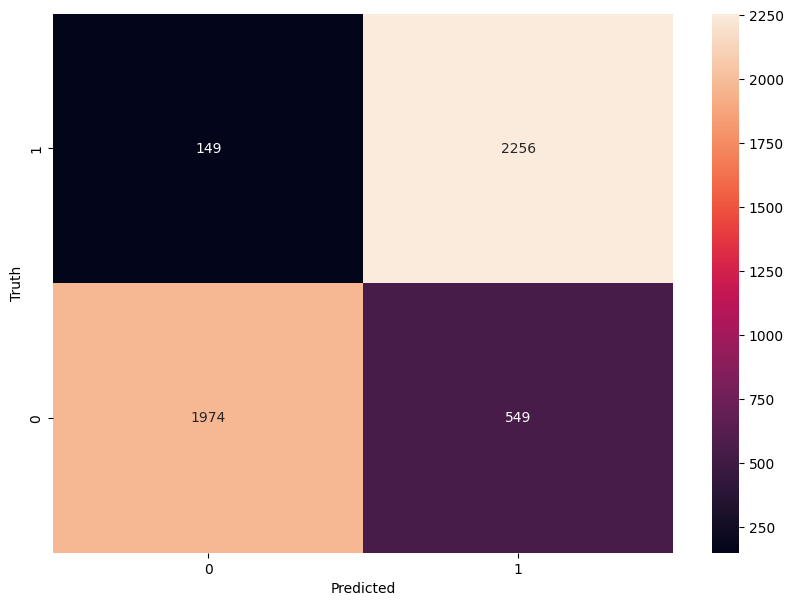

In [ ]:
# confusion matrix 생성
cm = confusion_matrix(true_labels, predictions)

# confusion matrix를 heatmap으로 그리기
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# y축의 위아래를 바꾸기
plt.gca().invert_yaxis()

plt.show()

> 예시코드

```
# confusion matrix 생성
cm = confusion_matrix(true_labels, predictions)

# confusion matrix를 heatmap으로 그리기
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# y축의 위아래를 바꾸기
plt.gca().invert_yaxis()

plt.show()
```

위에서부터 오른쪽 방향으로  
FN, TP  
TN, TP  입니다.  

TN과 TP가 고루 높고, FP와 FN도 고루 낮으며 어느 한 쪽으로 치우침 없이 모델이 훈련된 것을 확인할 수 있습니다.  

이번에는 모델의 결과를 바탕으로 Classification report를 생성해보겠습니다.  

위에서 확인한 Confusion matrix와 유사하게, 평가지표 값들이 어느 한 쪽으로 치우쳐져 있지는 않은 것을 확인할 수 있습니다.  

즉 이 모델은 클래스 0과 1을 비교적 잘 분류하며, 정밀도와 재현율이 균형을 이루고 있음을 알 수 있습니다.

다만 절대적인 정확도가 다소 낮기에, 이는 추가적인 데이터 전처리와 다른 발전된 여러 모델 훈련을 통해 개선할 수 있을 것으로 보입니다.  